In [9]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
import ProgressMeter
using CSV
using DataFrames

In [10]:
import ReactiveMP.messageout

In [11]:
data_seed, params_seed = 42, 420

(42, 420)

In [150]:
# find order
delay_y, delay_u, delay_e = 3, (3+1), 3
order_h = delay_e + 1

4

In [151]:
full_order = delay_e + delay_y + delay_u
Y = zeros(full_order, delay_y); Y[1:delay_y, 1:delay_y] = diageye(delay_y);
U = zeros(full_order, delay_u); U[delay_y+1:delay_y+delay_u, 1:delay_u] = diageye(delay_u);
H = zeros(full_order, order_h); H[full_order-delay_e+1:full_order, order_h-delay_e+1:order_h] = diageye(delay_e);

In [152]:
full_order = delay_e + delay_y + delay_u
Y = zeros(full_order, delay_y); Y[1:delay_y, 1:delay_y] = diageye(delay_y);
U = zeros(full_order, delay_u); U[delay_y+1:delay_y+delay_u, 1:delay_u] = diageye(delay_u);
H = zeros(full_order, order_h); H[full_order-delay_e+1:full_order, order_h-delay_e+1:order_h] = diageye(delay_e);

In [186]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function narmax(n, model_flow::FlowModel, params_flow, h_prior, w_prior, η_prior, τ_prior, y_prev, u, delay_y, delay_u, delay_e)
    
    order = delay_y + delay_u + delay_e
    order_h = delay_e + 1
    
    obs_prec = 1e12;
    
    # initialize variables
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(order_h), 1e12*diageye(order_h)))}
    w       = randomvar()
    h       = randomvar(n)
    uh      = randomvar(n)
    yuh     = randomvar(n)
    yuh_     = randomvar(n)
    yuh__     = randomvar(n)
    y       = datavar(Float64, n)

    y_nodes = Vector{FactorNode}(undef, n)

    Ys = [Y*y_prev[t] for t in 1:n]
    Us = [U*u[t] for t in 1:n]
    
    AR_meta_1 = ARMeta(Multivariate, order_h, ARsafe())
    AR_meta_2 = ARMeta(Multivariate, order, ARsafe())
    
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    w   ~ GammaShapeRate(w_prior[1], w_prior[2])
    θ   ~ MvNormalMeanPrecision(zeros(order_h), diageye(order_h))
    
    η   ~ MvNormalMeanPrecision(η_prior[1], η_prior[2])
    τ   ~ GammaShapeRate(τ_prior[1], τ_prior[2])
    
    b = zeros(order); b[1] = 1.0;
    c = zeros(order_h); c[1] = 1.0;
    
    Flow_meta  = FlowMeta(compile(model_flow, params_flow), Linearization())
#     Flow_meta  = FlowMeta(compile(model_flow, params_flow), Unscented(order))
    
    h_prev = h_0
    for t in 1:n
        
        h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta_1}
        uh[t] ~ H*h[t] + Us[t]
        yuh[t] ~ uh[t] + Ys[t]
        
        yuh_[t] ~ Flow(yuh[t]) where { meta = Flow_meta}
        
        yuh__[t] ~ AR(yuh_[t], η, τ) where {q = q(y, x)q(γ)q(θ), meta = AR_meta_2}
                
        y_nodes[t], y[t] ~ NormalMeanPrecision(dot(yuh__[t], b) + dot(h[t], c), obs_prec)
        
        h_prev = h[t]
    end

    return θ, w, h, η, τ, yuh_, yuh__, y_nodes, y
end

narmax (generic function with 1 method)

In [187]:
function narmax_inference(observations, observations_prev, controls, model_flow::FlowModel, params_flow;
                          delay_y, delay_u, delay_e,
                          h_prior=(randn(delay_e+1), diageye(delay_e+1)),
                          w_prior=(1.0, 1.0), η_prior=(zeros(delay_y + delay_u + delay_e), diageye(delay_y + delay_u + delay_e)),
                          τ_prior=(1.0, 1.0), vmp_its=10)
    
    order = delay_y + delay_u + delay_e
    order_h = delay_e + 1

    n = length(observations)

    # define model
    model, (θ, w, h, η, τ, yuh_, yuh__, y_nodes, y) = narmax(n, model_flow::FlowModel, params_flow, h_prior, w_prior, η_prior, τ_prior, observations_prev, controls, delay_y, delay_u, delay_e,
                                                             options = (limit_stack_depth = 100, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    
    θ_buffer = nothing
    w_buffer = nothing
    η_buffer = nothing
    τ_buffer = nothing
    
    subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    
    subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    subscribe!(getmarginal(η), (x) -> η_buffer = x)
    subscribe!(getmarginal(w), (x) -> w_buffer = x)
    subscribe!(getmarginal(τ), (x) -> τ_buffer = x)

    subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginals!(h, MvNormalMeanPrecision(zeros(order_h), diageye(order_h)))
    setmarginal!(w, GammaShapeRate(w_prior[1], w_prior[2]))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(order_h), diageye(order_h)))
    setmarginal!(τ, GammaShapeRate(τ_prior[1], τ_prior[2]))
    setmarginal!(η, MvNormalMeanPrecision(η_prior[1], η_prior[2]))
    
    setmessages!(h, MvNormalMeanPrecision(zeros(order_h), diageye(order_h)))
    
    ProgressMeter.@showprogress for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, θ_buffer, w_buffer, η_buffer, τ_buffer, y_out_buffer
    
end

narmax_inference (generic function with 1 method)

In [211]:
df = DataFrame(CSV.File("datasets/cascadedtanks/dataBenchmark.csv"));
u_train, u_val, y_train, y_val = df[:,1], df[:,2], df[:,3], df[:,4]

# normalization
m_y, s_y = mean(y_train), std(y_train)
m_u, s_u = mean(u_train), std(u_train)
output_trn = (y_train .- m_y) ./ s_y
output_val = (y_val .- m_y) ./ s_y
input_trn = (u_train .- m_u) ./ s_u
input_val = (u_val .- m_u) ./ s_u;

output_trn = y_train
output_val = y_val
input_trn = input_trn
input_val = input_val

1024-element Vector{Float64}:
 -1.8238110623262187
 -1.8007910489176124
 -1.7828010384388628
 -1.768201029934708
 -1.754401021896534
 -1.7376010121109313
 -1.7139009983062414
 -1.6790009779778163
 -1.6296009492034838
 -1.5629009103523104
 -1.4776008606670765
 -1.3736008000895348
 -1.2524007294933992
  ⋮
 -1.5194008850145886
 -1.664000969240671
 -1.781401037623396
 -1.8702210893589466
 -1.9305611245055705
 -1.964391144210746
 -1.9751211504607173
 -1.9672511458766284
 -1.9459411334640568
 -1.916491116310128
 -1.8838010972689758
 -1.8519510787171036

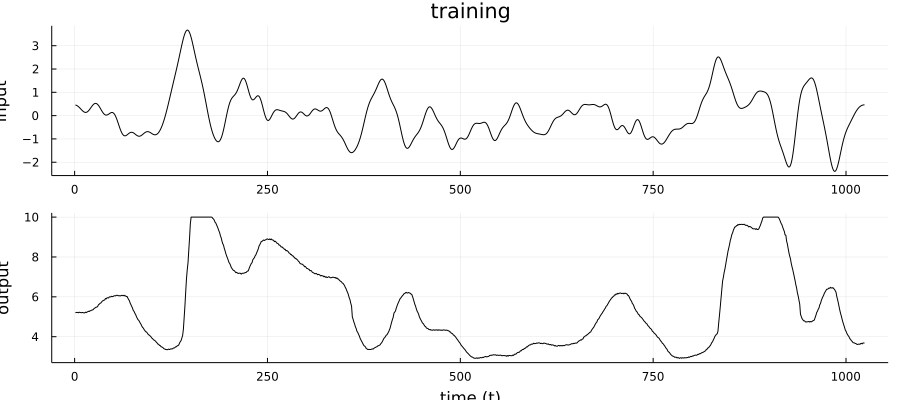

In [212]:
# Plot every n-th time-point to avoid figure size exploding
n = 1
ix = 1:n:length(output_trn)

# Plot training signals
p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

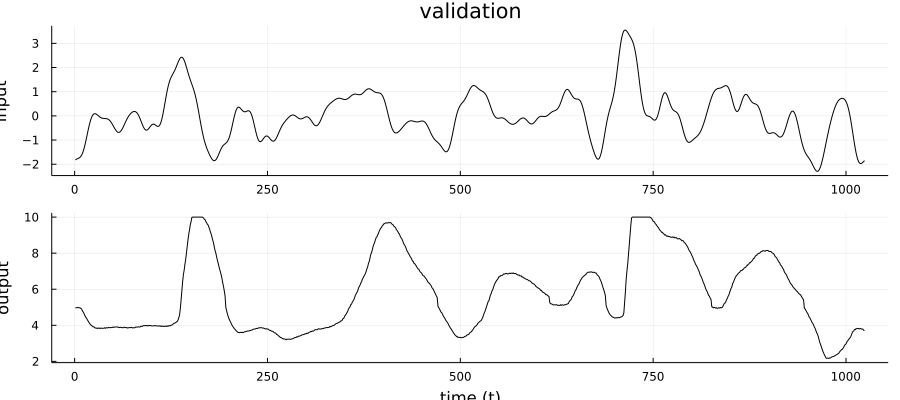

In [213]:
n = 1
ix = 1:n:length(output_val)

# Plot validation signals
p1a = plot(ix, input_val[ix], color="black", label="", xlabel="", ylabel="input", title="validation")    
p1b = plot(ix, output_val[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

In [214]:
function ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ssm (generic function with 1 method)

In [301]:
# specify flow model
model_flow = FlowModel(full_order,
    (
        AdditiveCouplingLayer(RadialFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(RadialFlow()),
        AdditiveCouplingLayer(RadialFlow()),
#         AdditiveCouplingLayer(RadialFlow()),
    )
);

In [331]:
# specify flow model
model_flow = FlowModel(full_order,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow()),
#         AdditiveCouplingLayer(PlanarFlow())
    )
);

In [217]:
# specify flow model
model_flow = FlowModel(full_order,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(RadialFlow()),
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(RadialFlow())
    )
);

In [332]:
train_size = 1000
test_size = 1000

# Generate training data
observations_prev, observations = ssm(output_trn, delay_y)
controls = ssm(input_trn, delay_u)[1]
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size];

# Generate validation data
observations_prev, observations = ssm(output_val, delay_y)
controls = ssm(input_val, delay_u)[1]
X_test, Y_test, U_test = observations_prev[1:test_size], observations[1:test_size], controls[1:test_size];

In [333]:
Random.seed!(params_seed)

flow_param_len = nr_params(model_flow)
flow_params    = 1/flow_param_len*ones(flow_param_len);
# flow_params = rand(flow_param_len)

In [334]:
full_order = delay_y + delay_u + delay_e
coefs_precision = diageye(full_order)
# coefs_mean = zeros(full_order); coefs_mean[end-delay_e+1:end] = zeros(delay_e)
# coefs_precision[end-delay_e+1:end,end-delay_e+1:end] = diageye(delay_e)

fe_, h_, θ_, w_, η_, τ_, y_out_ = narmax_inference(Y_train, X_train, U_train, model_flow, flow_params, 
                                                   delay_y=delay_y, delay_u=delay_u, delay_e=delay_e, 
                                                   w_prior=(1e4, 1.0), η_prior=(coefs_mean, coefs_precision), 
                                                   τ_prior=(1e2, 1.0), vmp_its=20);



Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


In [335]:
# Optimization function
function FE(model_params, p=nothing)
    fe_, h_, θ_, w_, η_, τ_, y_out_ = narmax_inference(Y_train, X_train, U_train, model_flow, model_params, 
                                                       delay_y=delay_y, delay_u=delay_u, delay_e=delay_e, 
                                                       w_prior=(1e4, 1.0), η_prior=(coefs_mean, coefs_precision), 
                                                       τ_prior=(1e2, 1.0), vmp_its=20);
    
    return fe_[end]
end;

In [336]:
Base.Float64(x::HugeNumber) = convert(Float64, x)

In [ ]:
using Optim

res = optimize(FE, flow_params, LBFGS(), Optim.Options(g_tol = 1e-8, iterations = 100, store_trace = true, show_trace = true, show_every=1), autodiff=:forward)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


Iter     Function value   Gradient norm 
     0    -1.040140e+03     5.368079e+00
 * time: 2.9802322387695312e-5


Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 

     1    -1.070661e+03     2.901602e+01
 * time: 2314.640058994293


Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

     2    -1.072078e+03     2.957972e+01
 * time: 3327.511740922928


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

     3    -1.076113e+03     8.343083e+01
 * time: 3861.4027359485626


Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 

     4    -1.082590e+03     8.798786e+01
 * time: 9146.662425994873


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:49:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

     5    -1.084050e+03     7.469061e+01
 * time: 26771.888175964355


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 

     6    -1.087496e+03     6.680417e+01
 * time: 27272.18085694313


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

     7    -1.090779e+03     5.034420e+01
 * time: 28025.412171840668


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 

     8    -1.090269e+03     5.084539e+01
 * time: 42332.71453881264


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

     9    -1.092183e+03     7.569503e+01
 * time: 43089.62099194527


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    10    -1.094573e+03     5.984522e+01
 * time: 43844.60499000549


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    11    -1.109502e+03     3.349219e+01
 * time: 44847.692945957184


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    12    -1.114822e+03     7.453333e+01
 * time: 45350.66037392616


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    13    -1.121975e+03     5.539899e+01
 * time: 46103.911027908325


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    14    -1.130678e+03     1.382965e+02
 * time: 46855.81475186348


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    15    -1.133517e+03     5.564611e+01
 * time: 47360.66104698181


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    16    -1.134621e+03     6.302877e+01
 * time: 47864.37771487236


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    17    -1.139055e+03     3.384576e+01
 * time: 48618.828246831894


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    18    -1.140668e+03     4.769096e+01
 * time: 49373.71756482124


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    19    -1.143072e+03     3.502681e+01
 * time: 63237.18920087814


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 

    20    -1.148239e+03     8.314710e+01
 * time: 63736.72187995911


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    21    -1.150766e+03     2.539275e+01
 * time: 64739.340213775635


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    22    -1.151764e+03     5.148438e+01
 * time: 66493.81829690933


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    23    -1.154217e+03     2.694879e+02
 * time: 67245.34578299522


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 

    24    -1.157493e+03     2.904599e+01
 * time: 67746.33339500427


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    25    -1.157804e+03     1.732924e+01
 * time: 68497.04735279083


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    26    -1.158902e+03     3.363570e+01
 * time: 82076.31671595573


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    27    -1.160705e+03     1.127062e+02
 * time: 82828.20610499382


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    28    -1.162792e+03     5.082080e+01
 * time: 83580.50202679634


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    29    -1.165122e+03     1.428853e+02
 * time: 84332.16253185272


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    30    -1.166849e+03     1.593144e+02
 * time: 85085.9702808857


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    31    -1.169033e+03     4.706373e+01
 * time: 85587.11947894096


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    32    -1.172832e+03     8.875419e+01
 * time: 86088.53731298447


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    33    -1.173032e+03     1.090636e+01
 * time: 87092.2616019249


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    34    -1.170268e+03     1.178666e+01
 * time: 102124.33642077446


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 

    35    -1.172735e+03     1.700817e+01
 * time: 102638.02313780785


Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:13:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 

    36    -1.174651e+03     4.902918e+01
 * time: 104169.82885885239


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    37    -1.174232e+03     4.238493e+01
 * time: 118309.87542295456


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    38    -1.174907e+03     2.313123e+01
 * time: 122567.194647789


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    39    -1.175961e+03     3.291205e+01
 * time: 136123.69237589836


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    40    -1.176955e+03     5.785947e+01
 * time: 150040.09047579765


Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
Progress: 100%|█████████████████████████████████████████| Time: 

    41    -1.174233e+03     4.012493e+01
 * time: 164418.6472108364


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    42    -1.175539e+03     6.002921e+01
 * time: 164921.39409279823


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    43    -1.179988e+03     1.180002e+02
 * time: 165424.44980978966


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    44    -1.183087e+03     7.463748e+01
 * time: 166179.39868593216


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    45    -1.191052e+03     5.248997e+02
 * time: 166936.19548988342


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    46    -1.204871e+03     1.468815e+02
 * time: 167440.22087192535


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    47    -1.212259e+03     6.188282e+02
 * time: 167943.5653629303


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    48    -1.212764e+03     6.034456e+02
 * time: 168447.76468896866


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    49    -1.217321e+03     5.334686e+01
 * time: 168950.5924949646


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    50    -1.217915e+03     1.589128e+02
 * time: 169452.21712899208


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    51    -1.218786e+03     9.352510e+01
 * time: 170205.75451993942


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    52    -1.219060e+03     4.674933e+01
 * time: 170708.25160193443


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    53    -1.220889e+03     6.163359e+01
 * time: 171461.94514083862


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    54    -1.223248e+03     7.516371e+01
 * time: 172225.196944952


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 

    55    -1.224887e+03     7.638007e+01
 * time: 173312.4688448906


Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    56    -1.228560e+03     2.760075e+02
 * time: 174097.57974600792


Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 

    57    -1.233948e+03     3.107459e+02
 * time: 174908.5592417717


Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    58    -1.242017e+03     5.069693e+02
 * time: 175452.74940800667


Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 

    59    -1.244228e+03     4.465979e+02
 * time: 176257.9967019558


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 

    60    -1.247052e+03     1.321245e+02
 * time: 176789.904599905


Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 

    61    -1.248358e+03     2.903679e+02
 * time: 190529.28352499008


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    62    -1.250032e+03     7.306172e+01
 * time: 191279.08323192596


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    63    -1.257656e+03     7.798787e+01
 * time: 192279.73543190956


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 

    64    -1.259352e+03     1.507753e+03
 * time: 193028.5342028141


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    65    -1.265975e+03     2.471612e+02
 * time: 193779.41252088547


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    66    -1.266897e+03     8.713207e+01
 * time: 194529.15423989296


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    67    -1.267232e+03     4.381084e+01
 * time: 195029.02856492996


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 

    68    -1.267499e+03     2.246958e+02
 * time: 195779.98405385017


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 

    69    -1.268792e+03     1.140936e+02
 * time: 200291.68707299232


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    70    -1.266774e+03     1.006985e+02
 * time: 213518.96218299866


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 

    71    -1.268893e+03     4.157269e+01
 * time: 214019.20941591263


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 

    72    -1.269127e+03     4.016938e+01
 * time: 215765.39938998222


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 

    73    -1.268281e+03     4.339548e+01
 * time: 230282.6228878498


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 

    74    -1.268412e+03     4.208699e+01
 * time: 230774.6263217926


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 

    75    -1.268770e+03     4.947916e+01
 * time: 246763.1558690071


Progress: 100%|█████████████████████████████████████████| Time: 0:00:41
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    76    -1.269389e+03     1.258815e+02
 * time: 247840.23457288742


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    77    -1.269166e+03     1.067604e+02
 * time: 262206.4526498318


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 

    78    -1.269348e+03     1.754655e+02
 * time: 263569.9421777725


Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    79    -1.269502e+03     2.803898e+01
 * time: 265410.3377249241


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    80    -1.269491e+03     3.018943e+01
 * time: 277238.56070280075


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    81    -1.268852e+03     3.638162e+01
 * time: 290364.6431708336


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 

    82    -1.268919e+03     8.454941e+01
 * time: 293403.2705068588


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    83    -1.269623e+03     3.222674e+01
 * time: 306796.80291986465


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    84    -1.269810e+03     3.423892e+02
 * time: 307555.3589668274


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    85    -1.269489e+03     2.997014e+02
 * time: 320684.77599692345


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    86    -1.270418e+03     1.049590e+02
 * time: 321189.43195295334


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    87    -1.270433e+03     6.754819e+01
 * time: 321941.3448019028


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    88    -1.270063e+03     6.729145e+01
 * time: 336134.8244459629


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 

    89    -1.270856e+03     1.921543e+02
 * time: 352067.4662568569


Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 

    90    -1.270651e+03     1.437025e+02
 * time: 364970.30260181427


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    91    -1.270481e+03     1.400991e+02
 * time: 378580.76905179024


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    92    -1.271103e+03     1.754034e+02
 * time: 379589.48996186256


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    93    -1.271576e+03     1.226187e+02
 * time: 392416.2587440014


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 

    94    -1.271368e+03     1.125288e+02
 * time: 405510.2379589081


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 

    95    -1.271117e+03     1.041026e+02
 * time: 418952.9122388363


Progress: 100%|█████████████████████████████████████████| Time: 0:00:57
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
Progress: 100%|█████████████████████████████████████████| Time: 

    96    -1.271453e+03     1.372073e+02
 * time: 419597.7408168316


Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 

    97    -1.270872e+03     8.152201e+01
 * time: 432844.38104486465


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:33
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 

    98    -1.271591e+03     2.469383e+02
 * time: 433881.1799829006


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:33
Progress: 100%|█████████████████████████████████████████| Time: 0:00:33
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:33
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 

    99    -1.270975e+03     2.378727e+02
 * time: 446846.79649686813


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 

   100    -1.272504e+03     1.497670e+02
 * time: 460022.9331037998


 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     -1.272504e+03

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 7.81e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.68e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.53e+00 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.20e-03 ≰ 0.0e+00
    |g(x)|                 = 1.50e+02 ≰ 1.0e-08

 * Work counters
    Seconds run:   460023  (vs limit Inf)
    Iterations:    100
    f(x) calls:    1757
    ∇f(x) calls:   1757


81-element Vector{Float64}:
  5.701860917762236
  0.204413392240557
 -1.1486483627134263
 -0.06594062607166816
 -0.040425060086529095
  0.06012370763299158
  3.4933872084981736
  0.6372445186150211
 -3.593090042252425
  5.141773270475053
  0.180251527053087
  4.760714142178991
 -5.51038919041087
  ⋮
 -0.4976965579223747
 -0.5951918368164488
  8.066957521411803
 -0.027506068105538527
  3.598979774668722
 -0.778233788025731
 -0.305099840696449
  0.31623640153844523
  0.06295189610306032
 -0.6109796960187922
  2.9852310755326283
  0.7682753273979344

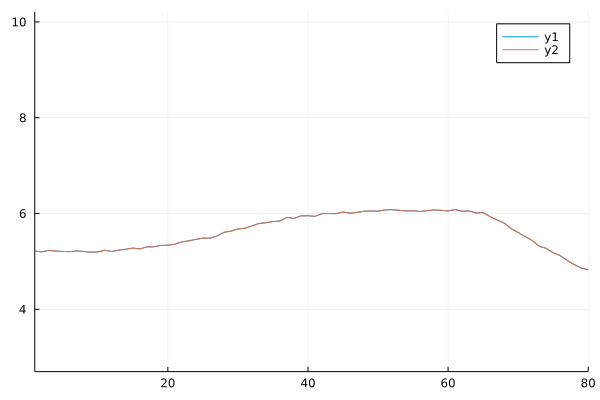

In [306]:
mfrom, mto = 1, 80
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(mfrom, mto))

In [307]:
mean(w_)

9960.427509812189

In [308]:
mean(τ_)

212.56865712530364

In [309]:
mean(η_)

10-element Vector{Float64}:
 -0.42983334481043256
  0.43198202067291985
 -0.03322571689891678
  0.7883236304747641
 -0.0015770711997356273
 -0.01975963304334484
 -0.0017557130648105897
 -0.0002738920968084598
 -0.0092711260286781
 -0.019821127524402276

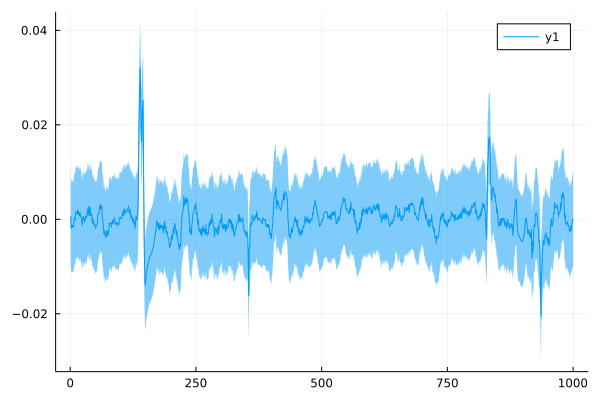

In [310]:
plot(first.(mean.(h_)), ribbon=sqrt.(first.(cov.(h_))))

## Prediction

In [311]:
function transition(γ, order)
    V = zeros(order, order)
#     V = diageye(order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [312]:
function prediction(h_prior, w_mle, η_posterior, τ_posterior, y_prev, u, flow_meta; full_order, h_order, nsamples=100)
    h_out = @call_rule MvNormalMeanCovariance(:out, Marginalisation) (m_μ=MvNormalMeanPrecision(mean(h_prior), precision(h_prior)), q_Σ=PointMass(transition(mean(w_), order_h)))
    Ys = Y*y_prev
    Us = U*u
    h_ = @call_rule typeof(*)(:out, Marginalisation) (m_A=PointMass(H), m_in=h_out)
    uh = @call_rule typeof(+)(:out, Marginalisation) (m_in1=PointMass(Us), m_in2=h_)
    yuh = @call_rule typeof(+)(:out, Marginalisation) (m_in1=PointMass(Ys), m_in2=uh)
    yuh_ = @call_rule Flow(:out, Marginalisation) (m_in=yuh, meta=flow_meta)
    ar_out = @call_rule AR(:y, Marginalisation) (m_x=yuh_, q_θ=η_posterior.data, q_γ=τ_posterior.data, meta=ARMeta(Multivariate, full_order, ARsafe()))
    c = zeros(full_order); c[1] = 1.0
    dot_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=ar_out, meta=ReactiveMP.TinyCorrection())
    c = zeros(h_order); c[1] = 1.0
    c_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=h_out, meta=ReactiveMP.TinyCorrection())
    @call_rule typeof(+)(:out, Marginalisation) (m_in1=dot_out, m_in2=c_out)
end

prediction (generic function with 1 method)

In [340]:
h_prior = h_[end]
flow_meta = FlowMeta(compile(model_flow, res.minimizer), Linearization())
prediction(h_prior, mean(w_), η_, τ_, X_test[1], U_test[1], flow_meta, full_order=full_order, h_order=order_h, nsamples=1000)

NormalMeanVariance{Float64}(μ=6.334368419454395, v=0.011489920238131064)

In [341]:
predictions = []
h_prior = h_[end]
w_prior = w_
τ_prior = τ_
ProgressMeter.@showprogress for i in 1:length(Y_test)
    pred = prediction(h_prior, mean(w_), η_, τ_, X_test[i], U_test[i], flow_meta, full_order=full_order, h_order=order_h, nsamples=1000)
    push!(predictions, pred)
    _, h_post, θ_post, w_post, η_post, τ_post, _ = narmax_inference([Y_test[i]], [X_test[i]], [U_test[i]], model_flow, flow_params,
                                                                    delay_y=delay_y, delay_u=delay_u, delay_e=delay_e, 
                                                                    h_prior=(mean(h_prior), precision(h_prior)),
                                                                    w_prior=(shape(w_prior), rate(w_prior)), 
                                                                    η_prior=(mean(η_), precision(η_)),
                                                                    τ_prior=(shape(τ_prior), rate(τ_prior)), vmp_its=10);
    h_prior = h_post[end]
#     η_prior = η_post
#     τ_prior = τ_post
#     w_prior = w_post
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


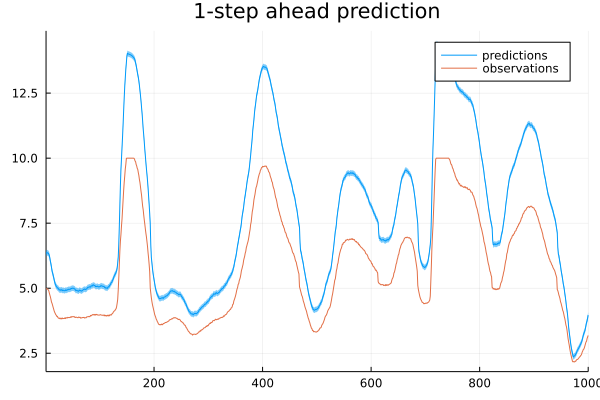

In [342]:
plot(mean.(predictions), ribbon=sqrt.(first.(cov.(predictions))), label="predictions")
plot!(Y_test, xlims=(1, 1000), title="1-step ahead prediction", label="observations")

In [343]:
RMSE = sqrt(mean((mean.(predictions) .- Y_test) .^2))

2.2542789901620806

In [344]:
w_prior

Marginal(GammaShapeRate{Float64}(a=10500.0, b=1.0497683589120124))

In [345]:
h_prior = h_[end]
w_prior = w_
τ_prior = τ_
η_prior = η_

simulated_X = [X_test[1]]
simulated_Y = [Y_test[1]]
simulated_Y_cov = [0.0]
ProgressMeter.@showprogress for i in 1:length(Y_test)
       _, h_post, θ_post, w_post, η_post, τ_post, y_out_post = narmax_inference([simulated_Y[i]], [simulated_X[i]], [U_test[i]],
                                                                                 model_flow, flow_params,
                                                                                 delay_y=delay_y, delay_u=delay_u, delay_e=delay_e, 
                                                                                 h_prior=(mean(h_prior), precision(h_prior)),
                                                                                 w_prior=(shape(w_prior), rate(w_prior)), 
                                                                                 η_prior=(mean(η_), precision(η_)),
                                                                                 τ_prior=(shape(τ_prior), rate(τ_prior)), vmp_its=10);
    
    h_prior = h_post[end]
    η_prior = η_post
    τ_prior = τ_post
    w_prior = w_post
    
    push!(simulated_X, [mean.(y_out_post)[1]; simulated_X[i][1:delay_y-1]])
    pred_sim = prediction(h_prior, mean(w_), η_prior, τ_, [mean.(y_out_post)[1]; simulated_X[i][1:delay_y-1]], U_test[i], flow_meta, full_order=full_order, h_order=order_h)

    push!(simulated_Y, mean(pred_sim))
    push!(simulated_Y_cov, var(pred_sim))

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


In [346]:
RMSE = sqrt(mean((simulated_Y[from:to] .- Y_test[from:to]).^2))

1087.2067597451799

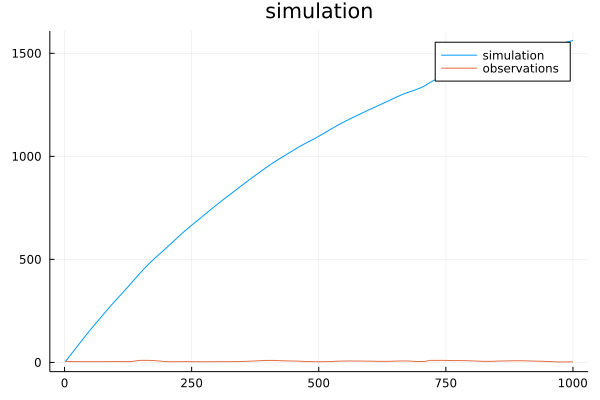

In [347]:
from, to = 1, 1000
plot(simulated_Y[from:to],  ribbon=simulated_Y_cov[from:to], label="simulation")
# plot!(first.(U_test[from:to]), label="controls")
plot!(Y_test[from:to], title="simulation", label="observations")

In [ ]:
function loss_function(params_fl)
    
    h_prior = h_[end]
    w_prior = w_
    τ_prior = τ_
    η_prior = η_

    simulated_X = [X_test[1]]
    simulated_Y = [Y_test[1]]
    simulated_Y_cov = [0.0]
    
    for i in 1:length(Y_test)
        _, h_post, θ_post, w_post, η_post, τ_post, y_out_post = narmax_inference([simulated_Y[i]], [simulated_X[i]], [U_test[i]],
                                                                                 model_flow, params_fl,
                                                                                 delay_y=delay_y, delay_u=delay_u, delay_e=delay_e, 
                                                                                 h_prior=(mean(h_prior), precision(h_prior)),
                                                                                 w_prior=(shape(w_prior), rate(w_prior)), 
                                                                                 η_prior=(mean(η_), precision(η_)),
                                                                                 τ_prior=(shape(τ_prior), rate(τ_prior)), vmp_its=10);

        h_prior = h_post[end]
        η_prior = η_post
        τ_prior = τ_post
        w_prior = w_post

        push!(simulated_X, [mean.(y_out_post)[1]; simulated_X[i][1:delay_y-1]])
        pred_sim = prediction(h_prior, mean(w_), η_prior, τ_, [mean.(y_out_post)[1]; simulated_X[i][1:delay_y-1]], U_test[i], full_order=full_order, h_order=order_h)

        push!(simulated_Y, mean(pred_sim))
        push!(simulated_Y_cov, var(pred_sim))

    end
    
    RMSE = sqrt(mean((simulated_Y[from:to] .- Y_test[from:to]).^2))
end

In [ ]:
res = optimize(loss_function, flow_params, LBFGS(), Optim.Options(g_tol = 1e-8, iterations = 100, store_trace = true, show_trace = true, show_every=1), autodiff=:forward)

In [171]:
?RadialFlow

search: RadialFlow



The RadialFlow function is defined as

$$
f({\bf{x}}) = {\bf{x}} + \frac{\beta({bf{z}} - {\bf{z}}_0)}{\alpha + |{\bf{z}} - {\bf{z}}_0|}
$$

with input and output dimension $D$. Here ${\bf{x}}\in \mathbb{R}^D$ represents the input of the function. Furthermore ${\bf{z}}_0\in \mathbb{R}^D$, $\alpha\in \mathbb{R}$ and $\beta\in\mathbb{R}$ represent the parameters of the function. The function contracts and expands the input space. 

This function has been introduced in:

Rezende, Danilo, and Shakir Mohamed. "Variational inference with normalizing flows." *International conference on machine learning.* PMLR, 2015.

---

The `RadialFlow()` function creates a planar flow object. Its dimensionality is automatically set when wrapping this object inside a model. Its parameters are initialized during compilation.

---

The `RadialFlow(dim::Int64)` function creates a mutable `RadialFlow` structure with parameters corresponding to input of dimensions `dim`. The parameters are each random sampled from a standard (multivariate) normal distribution.


In [ ]:
radial(x) = x + ()

In [172]:
?ReactiveMP.forward

No documentation found.

`ReactiveMP.forward` is a `Function`.

```
# 10 methods for generic function "forward":
[1] forward(f::PlanarFlow{T1, T2}, input::T3) where {T1<:Real, T2<:Real, T3<:Real} in ReactiveMP at /Users/apodusenko/.julia/dev/ReactiveMP/src/nodes/flow/coupling_flows/planar_flow.jl:131
[2] forward(f::PlanarFlow{T1, T2}, input::T1) where {T1, T2<:Real} in ReactiveMP at /Users/apodusenko/.julia/dev/ReactiveMP/src/nodes/flow/coupling_flows/planar_flow.jl:112
[3] forward(f::PlanarFlow{T1, T2}, input) where {T1<:Real, T2<:Real} in ReactiveMP at /Users/apodusenko/.julia/dev/ReactiveMP/src/nodes/flow/coupling_flows/planar_flow.jl:139
[4] forward(f::RadialFlow{T1, T2}, input::T3) where {T1<:Real, T2<:Real, T3<:Real} in ReactiveMP at /Users/apodusenko/.julia/dev/ReactiveMP/src/nodes/flow/coupling_flows/radial_flow.jl:132
[5] forward(f::RadialFlow{T1, T2}, input::T1) where {T1, T2<:Real} in ReactiveMP at /Users/apodusenko/.julia/dev/ReactiveMP/src/nodes/flow/coupling_flows/radial_flow.jl:109
[6] forward(f::RadialFlow{T1, T2}, input) where {T1<:Real, T2<:Real} in ReactiveMP at /Users/apodusenko/.julia/dev/ReactiveMP/src/nodes/flow/coupling_flows/radial_flow.jl:140
[7] forward(layer::AdditiveCouplingLayer, input::AbstractVector{var"#s929"} where var"#s929"<:Real) in ReactiveMP at /Users/apodusenko/.julia/dev/ReactiveMP/src/nodes/flow/layers/additive_coupling_layer.jl:116
[8] forward(layer::PermutationLayer, input::AbstractVector{var"#s929"} where var"#s929"<:Real) in ReactiveMP at /Users/apodusenko/.julia/dev/ReactiveMP/src/nodes/flow/layers/permutation_layer.jl:73
[9] forward(model::CompiledFlowModel, input::AbstractVector{var"#s929"} where var"#s929"<:Real) in ReactiveMP at /Users/apodusenko/.julia/dev/ReactiveMP/src/nodes/flow/flow_models/flow_model.jl:145
[10] forward(model::FlowModel, input::AbstractVector{var"#s929"} where var"#s929"<:Real) in ReactiveMP at /Users/apodusenko/.julia/dev/ReactiveMP/src/nodes/flow/flow_models/flow_model.jl:511
```


In [50]:
# specify flow model
model_test = FlowModel(2,
    (
        AdditiveCouplingLayer(RadialFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(RadialFlow()),
        AdditiveCouplingLayer(RadialFlow()),
    )
);

test_params = 1/nr_params(model_test)*ones(nr_params(model_test))
# test_params = rand(nr_params(model_test))

9-element Vector{Float64}:
 0.1111111111111111
 0.1111111111111111
 0.1111111111111111
 0.1111111111111111
 0.1111111111111111
 0.1111111111111111
 0.1111111111111111
 0.1111111111111111
 0.1111111111111111

In [51]:
c_model_test = compile(model_test, test_params)

CompiledFlowModel{6, Tuple{AdditiveCouplingLayer{Tuple{RadialFlow{Float64, Float64}}}, PermutationLayer{Int64}, AdditiveCouplingLayer{Tuple{RadialFlow{Float64, Float64}}}, PermutationLayer{Int64}, AdditiveCouplingLayer{Tuple{RadialFlow{Float64, Float64}}}, PermutationLayer{Int64}}}(2, (AdditiveCouplingLayer{Tuple{RadialFlow{Float64, Float64}}}(2, (RadialFlow{Float64, Float64}(0.1111111111111111, 0.1111111111111111, 0.1111111111111111),), 1), PermutationLayer{Int64}(2, [0 1; 1 0]), AdditiveCouplingLayer{Tuple{RadialFlow{Float64, Float64}}}(2, (RadialFlow{Float64, Float64}(0.1111111111111111, 0.1111111111111111, 0.1111111111111111),), 1), PermutationLayer{Int64}(2, [0 1; 1 0]), AdditiveCouplingLayer{Tuple{RadialFlow{Float64, Float64}}}(2, (RadialFlow{Float64, Float64}(0.1111111111111111, 0.1111111111111111, 0.1111111111111111),), 1), PermutationLayer{Int64}(2, [0 1; 1 0])))

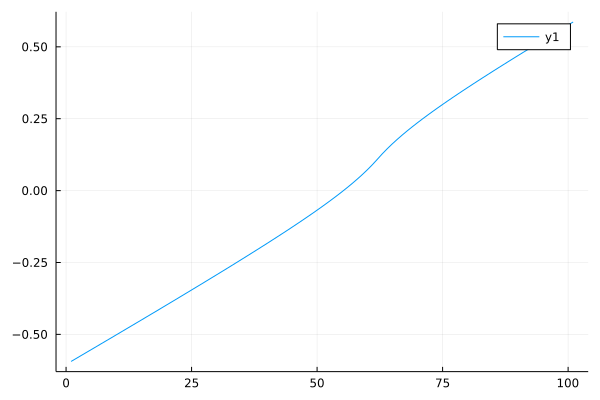

In [52]:
plot(ReactiveMP.forward.(c_model_test.layers[1].f[1], collect(-0.5:0.01:0.5)))

In [74]:
samples = []
flowed = []
plt_1 = plot(legend=false)
plt_2 = plot(legend=false)
for i in 1:10
    push!(samples, randn(2))
    push!(flowed, ReactiveMP.forward(compile(model_test, test_params), samples[end]))
    scatter!(plt_1, [first(samples[end])], [last(samples[end])], c=i, markersize=5)
    
    scatter!(plt_2, [first(flowed[end])], [last(flowed[end])], c=i, markersize=5)
end

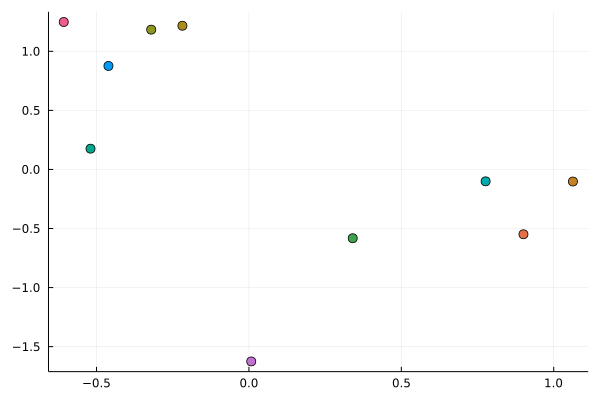

In [75]:
plt_1

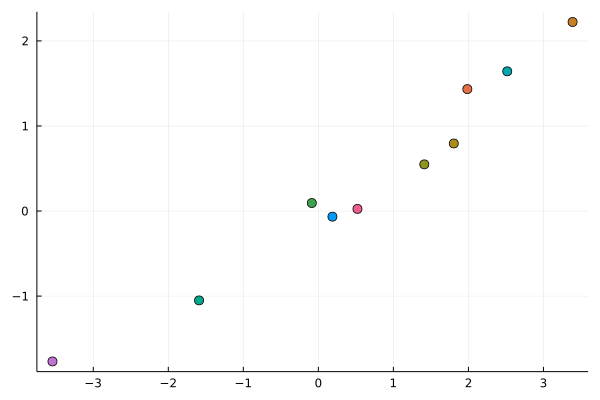

In [76]:
plt_2